## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Managament](#2)
    -  [2.1.Downloading and Extracting Dataset](#2.1)
    -  [2.2.Visualizing Dataset](#2.2)
    -  [2.3.Splitting Dataset](#2.3)
    -  [2.4.Pytorch DataLoaders](#2.4)
-  [3.Initializing pre-trained model](#3)
-  [4.Training](#4)
-  [5.Plotting Graphs](#5)
    -  [5.1.Plotting Loss vs MiniBatch](#5.1)
    -  [5.2.Plotting Accuracy vs MiniBatch](#5.2)
    -  [5.3.Plotting Loss vs Epoch](#5.3)
    -  [5.4.Plotting Accuracy vs Epoch](#5.4)
-  [6.Loading and Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from sklearn import cluster
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
import pickle

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")



### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="2.1"></a>

In [2]:
# !kaggle datasets download -d jarvisgroot/brain-tumor-classification-mri-images
if len(os.listdir('data/')) == 0:
    ZipFile("brain-tumor-classification-mri-images.zip").extractall("data/")

In [3]:
path = 'data/brain_tumor_mri/new_dataset/'
print(os.listdir(path))

['bt_images', 'labels.pickle', 'training_data.pickle']


In [4]:
training_data = pickle.load(open(path+'training_data.pickle','rb'))
random.shuffle(training_data)

In [5]:
total_data_len = len(training_data)
classes = ['Meningioma', 'Glioma', 'Pitutary']
n_classes = len(classes)

x_raw = []
y_raw = []

for i in training_data:
    x_raw.append(i[0])
    y_raw.append(i[1])

y_raw = list(np.asarray(y_raw)-np.ones(total_data_len,dtype=np.int))

#### 2.Visualizing Dataset <a class="anchor" id="2.2"></a>

In [6]:
print(f'Total number of images : {total_data_len}')

Total number of images : 3064


Pitutary


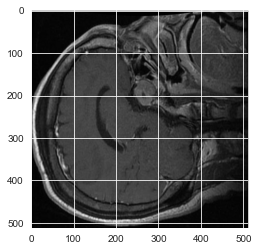

In [7]:
plt.imshow(x_raw[0])
print(classes[y_raw[0]])

Number of scans with Meningioma : 708 Glioma : 1426 Pitutary : 930


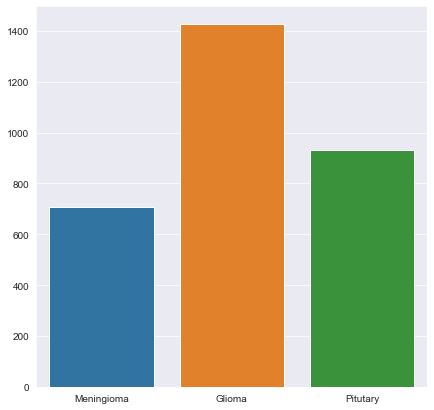

In [8]:
each_class = [0,0,0]
for i in y_raw:
    for j in range(n_classes):
        if i == j:
            each_class[j] = each_class[j] + 1
print(f'Number of scans with Meningioma : {each_class[0]} Glioma : {each_class[1]} Pitutary : {each_class[2]}')            
ax, fig = plt.subplots(figsize=[7,7])
sns.barplot(x=classes, y=each_class)
plt.show()

In [9]:
sample = []
sample_size = 4
for i in range(n_classes):
    temp = []
    key = 0
    while True:
        index = y_raw.index(i,key,total_data_len-1)
        key = index+1
        temp.append(x_raw[index])
        
        if len(temp) == sample_size:
            break
            
    sample.append(temp)
sample = np.asarray(sample)
print(f'sample contains {len(sample)} classes with {len(sample[0])} samples in each class')

sample contains 3 classes with 4 samples in each class


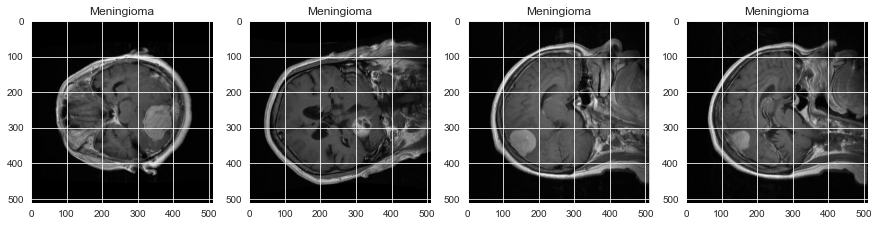

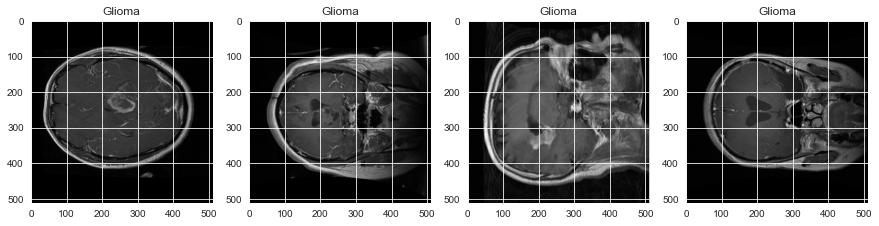

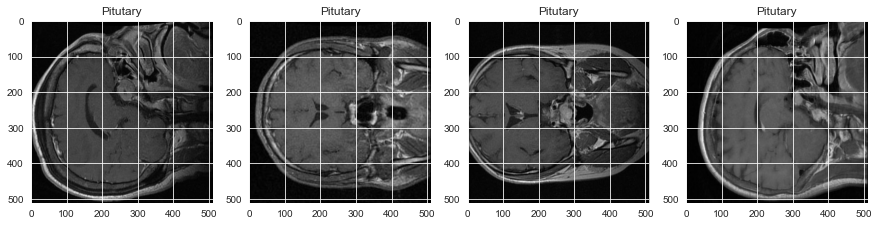

In [10]:
for i in range(n_classes):
    fig = plt.figure(figsize=(15,15))
    for j in range(sample_size):
        fig.add_subplot(i+1,sample_size ,j+1)
        plt.title(classes[i])
        plt.imshow(sample[i][j])


In [11]:
def clustered_img(x):
    kmeans = cluster.KMeans(5)
    dims = np.shape(x)
    pixel_matrix = np.reshape(x, (dims[0] * dims[1], dims[2]))
    clustered = kmeans.fit_predict(pixel_matrix)


    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    return clustered_img

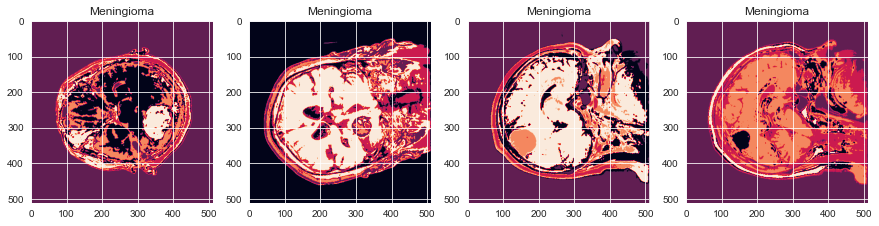

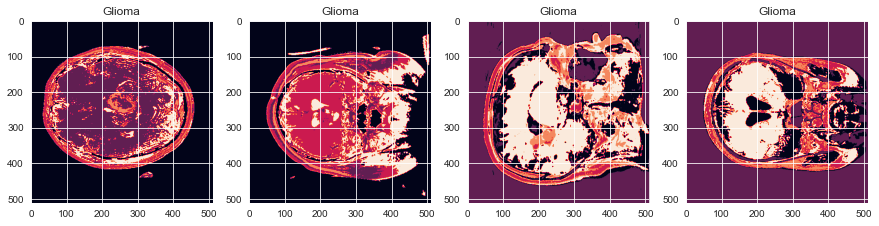

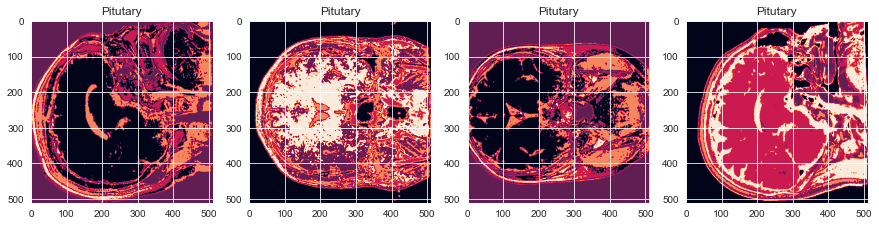

In [12]:
for i in range(n_classes):
    fig = plt.figure(figsize=(15,15))
    for j in range(sample_size):
        fig.add_subplot(i+1,sample_size ,j+1)
        plt.title(classes[i])
        plt.imshow(clustered_img(sample[i][j]))


#### 3.Splitting Dataset <a class="anchor" id="2.3"></a>

In [13]:
n_train = int(0.95 *total_data_len)
n_validation = int(0.021*total_data_len)

train_image = x_raw[:n_train]
train_label = y_raw[:n_train]

validation_image = x_raw[n_train:n_train+n_validation]
validation_label = y_raw[n_train:n_train+n_validation]

test_image = x_raw[n_train:n_train+n_validation:]
test_label = y_raw[n_train:n_train+n_validation:]

#### 4.Pytorch DataLoaders <a class="anchor" id="2.4"></a>

In [14]:
class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y 
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        return torch.FloatTensor(np.asarray(self.transform(Image.fromarray(self.x[i])))),torch.LongTensor([self.y[i]])

batch_size = 16

transforms_train = T.Compose([
        T.Resize((224,224)),
        T.RandomRotation(degrees=(-45, 45)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Dataset(train_image,train_label,transform =transforms_train)
validation_dataset = Dataset(validation_image,validation_label,transform =transforms_test)
test_dataset = Dataset(test_image,test_label,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True )

In [15]:
next(iter(train_dataloader))[0].shape

torch.Size([16, 3, 224, 224])

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [16]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)


### 4.Training <a class="anchor" id="4"></a>

In [17]:
lr = 0.0015
epoch = 15
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)


#Displaying the model summary
from torchsummary import summary
summary(model, (3,224,224), batch_size=16, device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

In [18]:
for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % 30 == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),'saved_model/resnet50_v1')
    
    #Log for e+1th epoch
    print(f'--------------------------------------------------------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    n_validation_losses = int(train_n_minibatches/30)*validation_n_minibatches
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}',end = ' ')
    print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 BATCH 0/182 TRAIN LOSS : 1.2265915870666504 TRAIN ACCURACY : 12.5 VALIDATION LOSS : 1.0709354877471924 VALIDATION ACCURACY : 51.5625
LOSS for EPOCH 1 BATCH 30/182 TRAIN LOSS : 1.0296746492385864 TRAIN ACCURACY : 56.25 VALIDATION LOSS : 0.9273805022239685 VALIDATION ACCURACY : 60.9375
LOSS for EPOCH 1 BATCH 60/182 TRAIN LOSS : 0.8149574995040894 TRAIN ACCURACY : 68.75 VALIDATION LOSS : 0.856340765953064 VALIDATION ACCURACY : 65.625
LOSS for EPOCH 1 BATCH 90/182 TRAIN LOSS : 0.7155731916427612 TRAIN ACCURACY : 75.0 VALIDATION LOSS : 0.7289277464151382 VALIDATION ACCURACY : 68.75
LOSS for EPOCH 1 BATCH 120/182 TRAIN LOSS : 0.5627025961875916 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.6627925410866737 VALIDATION ACCURACY : 84.375
LOSS for EPOCH 1 BATCH 150/182 TRAIN LOSS : 0.6567028760910034 TRAIN ACCURACY : 81.25 VALIDATION LOSS : 0.6439666375517845 VALIDATION ACCURACY : 76.5625
LOSS 

LOSS for EPOCH 6 BATCH 120/182 TRAIN LOSS : 0.12167121469974518 TRAIN ACCURACY : 93.75 VALIDATION LOSS : 0.2482318263500929 VALIDATION ACCURACY : 92.1875
LOSS for EPOCH 6 BATCH 150/182 TRAIN LOSS : 0.0999046042561531 TRAIN ACCURACY : 100.0 VALIDATION LOSS : 0.2520434595644474 VALIDATION ACCURACY : 90.625
LOSS for EPOCH 6 BATCH 180/182 TRAIN LOSS : 0.20333844423294067 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.22581485845148563 VALIDATION ACCURACY : 93.75
--------------------------------------------------------------------------------------------
Loss for EPOCH 6  TRAIN LOSS : 0.21551904022939258 TRAIN ACCURACY : 91.78277080062794
VALIDATION LOSS for EPOCH 6 : 0.2393712162350615 VALIDATION ACCURACY : 92.44791666666667
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 7-------------------------------------------
LOSS for EPOCH 7 BATCH 0/182 TRAIN LOSS : 0.10055406391620636 TRAIN ACCURACY : 93.75 VALID

LOSS for EPOCH 12 BATCH 0/182 TRAIN LOSS : 0.038366492837667465 TRAIN ACCURACY : 100.0 VALIDATION LOSS : 0.177874518558383 VALIDATION ACCURACY : 96.875
LOSS for EPOCH 12 BATCH 30/182 TRAIN LOSS : 0.10292156785726547 TRAIN ACCURACY : 93.75 VALIDATION LOSS : 0.1736744288355112 VALIDATION ACCURACY : 96.875
LOSS for EPOCH 12 BATCH 60/182 TRAIN LOSS : 0.3339322805404663 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.17668830137699842 VALIDATION ACCURACY : 95.3125
LOSS for EPOCH 12 BATCH 90/182 TRAIN LOSS : 0.13828852772712708 TRAIN ACCURACY : 93.75 VALIDATION LOSS : 0.1811439711600542 VALIDATION ACCURACY : 96.875
LOSS for EPOCH 12 BATCH 120/182 TRAIN LOSS : 0.1735520362854004 TRAIN ACCURACY : 93.75 VALIDATION LOSS : 0.17360234819352627 VALIDATION ACCURACY : 95.3125
LOSS for EPOCH 12 BATCH 150/182 TRAIN LOSS : 0.22835084795951843 TRAIN ACCURACY : 93.75 VALIDATION LOSS : 0.1803379040211439 VALIDATION ACCURACY : 93.75
LOSS for EPOCH 12 BATCH 180/182 TRAIN LOSS : 0.4028031527996063 TRAIN ACCURACY : 

### 5.Plotting Graphs<a class="anchor" id="5"></a>

In [19]:
avg_loss_history = [[],[]]
avg_accuracy_history = [[],[]]

for i in range(0,len(loss_history[0]),30):
    avg_loss_history[0].append(sum(loss_history[0][i:i+30])/30)
    
for i in range(0,len(loss_history[1]),4):
    avg_loss_history[1].append(sum(loss_history[1][i:i+4])/4)
    
for i in range(0,len(accuracy_history[0]),30):
    avg_accuracy_history[0].append(sum(accuracy_history[0][i:i+30])/30)
    
for i in range(0,len(accuracy_history[1]),4):
    avg_accuracy_history[1].append(sum(accuracy_history[1][i:i+4])/4)



#### 1.Plotting Loss vs MiniBatch<a class="anchor" id="5.1"></a>

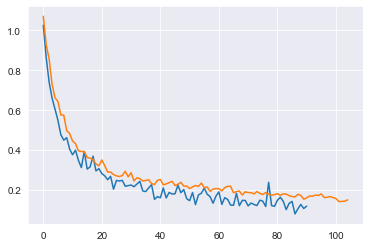

In [20]:
sns.lineplot(x=range(len(avg_loss_history[0])),y=avg_loss_history[0])
sns.lineplot(x=range(len(avg_loss_history[1])),y=avg_loss_history[1])
plt.show()


#### 2.Plotting Accuracy vs MiniBatch<a class="anchor" id="5.2"></a>

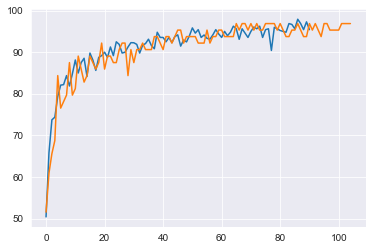

In [21]:
sns.lineplot(x=range(len(avg_accuracy_history[0])),y=avg_accuracy_history[0])
sns.lineplot(x=range(len(avg_accuracy_history[1])),y=avg_accuracy_history[1])
plt.show()

#### 3.Plotting Loss vs Epoch<a class="anchor" id="5.3"></a>

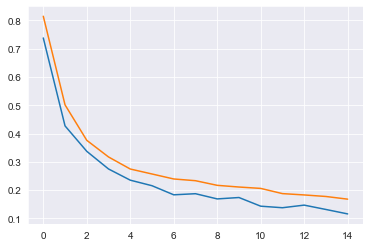

In [22]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])
plt.show()

#### 4.Plotting Accuracy vs Epoch<a class="anchor" id="5.4"></a>

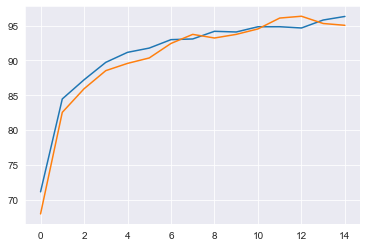

In [23]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(x=range(len(accuracy_per_epoch[0])),y=accuracy_per_epoch[0])
sns.lineplot(x=range(len(accuracy_per_epoch[1])),y=accuracy_per_epoch[1])
plt.show()

### 6.Loading and Testing<a class="anchor" id="6"></a>

In [24]:
#Loading the saved model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)
model.load_state_dict(torch.load('saved_model/resnet50_v1', map_location='cpu'))

<All keys matched successfully>

In [25]:
test_loss_history = []
test_accuracy_history = []

In [26]:
#Testing the model on test dataset
model = model.to('cpu')
model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    y_pred = model(x)
    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_pred = y_pred.detach().numpy().tolist()
    y = y.detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)
                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')                    

LOSS : 0.1528246495872736  ACCURACY : 96.875
